In [1]:
%pylab inline
import numpy as np
from parametric_pde_find import *
from robust_pde_diff import DLrSR, RobustPCA
from scipy.integrate import odeint
from numpy.fft import fft, ifft, fftfreq

from best_subset import *
from solvel0 import solvel0
from UBIC import fit_blr, UBIC, decreasing_values_indices

from sklearn.linear_model import BayesianRidge, ARDRegression, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split, KFold

from findiff import FinDiff

import warnings
warnings.filterwarnings("ignore")

def coeff_error(est, ground): return 100*np.linalg.norm(est-ground, 1)/np.linalg.norm(ground, 1)

def ssr2llf(ssr, nobs):
    nobs2 = nobs / 2.0
    llf = -nobs2 * np.log(2 * np.pi) - nobs2 * np.log(ssr / nobs) - nobs2
    return llf

def log_like_value(prediction, ground):                                                                                                               
    nobs = float(ground.shape[0])
    ssr = np.sum(np.abs(ground - prediction)**2)
    return ssr2llf(ssr, nobs)

def BIC_AIC(prediction, ground, nparams, reg_func = lambda x: x):
    nparams = reg_func(nparams)
    llf = log_like_value(prediction, ground)
    return -2*llf + np.log(ground.shape[0])*nparams, -2*llf + 2*nparams

def rss2bic(rss, nparams, nobs, epsilon=1e-5):
    return nobs*np.log(2*np.pi*rss/nobs+epsilon) + np.log(nobs)*nparams

def AIC_Loss(As,bs,x,epsilon=1e-5):
    # D: Number of candidates | m: either len(t) or len(x) (temporal or spatial group)
    D,m = x.shape
    # n: Number of horizon
    n,_ = As[0].shape
    N = n*m
    # Complexity
    k = np.count_nonzero(x)/m
    # AIC
    rss = [np.linalg.norm(bs[j] - As[j].dot(x[:,j].reshape(D,1)))**2 for j in range(m)]
    rss = np.sum(rss)
    return N*np.log(rss/N+epsilon) + 2*k + (2*k**2+2*k)/(N-k-1)

# Sensitivity to epsilon was never discussed!
def BIC_Loss(As,bs,x,epsilon=1e-5):
    # D: Number of candidates | m: either len(t) or len(x) (temporal or spatial group)
    D,m = x.shape
    # n: Number of horizon
    n,_ = As[0].shape
    N = n*m
    # Complexity
    k = np.count_nonzero(x)/m
    # BIC
    res = np.vstack([bs[j] - As[j]@x[:, j:j+1] for j in range(m)])
    assert len(res) == n*m
    rss = np.linalg.norm(res, ord=2)**2 
    # llf = ssr2llf(rss, N)
    # -2*llf + np.log(N)*k # AIC: -2*llf + 2*k
    # N*np.log(2*np.pi*rss/N) + np.log(N)*k
    return N*np.log(2*np.pi*rss/N+epsilon) + np.log(N)*k

np.random.seed(1234)
fontsize = 20

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.2.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.


In [2]:
def spatial_temporal_group(Theta, Ut, domain_shape, dependent="temporal"):
    n, m = domain_shape
    assert n*m == Theta.shape[0], Ut.shape[0]
    if dependent == "temporal":
        Theta_grouped = [(Theta[j*n:(j+1)*n,:]).real for j in range(m)]
        Ut_grouped = [(Ut[j*n:(j+1)*n]).real for j in range(m)]
    elif dependent == "spatial":
        Theta_grouped = [(Theta[n*np.arange(m)+j,:]).real for j in range(n)]
        Ut_grouped = [(Ut[n*np.arange(m)+j]).real for j in range(n)]
    else: return
    return Theta_grouped, Ut_grouped

def normalize_groups(As, bs, normalize=2):
    m = len(As)
    n,D = As[0].shape
    
    # get norm of each column
    candidate_norms = np.zeros(D)
    for i in range(D):
        candidate_norms[i] = Norm(np.vstack([A[:,i] for A in As]), normalize)

    norm_bs = [m*Norm(b, normalize) for b in bs]

    # normalize 
    for i in range(m):
        As[i] = As[i].dot(np.diag(candidate_norms**-1))
        bs[i] = bs[i]/norm_bs[i]
        
    return As, bs

def advection_rhs(u, t, params):
    k, L, x = params    
    kappa = -1.5 + 1.0*np.cos(2*x*np.pi/L)
    deriv = ifft(1j*k*fft(kappa*u)) + 0.1*ifft(-k**2*fft(u))
    return real(deriv)

In [3]:
# Set size of grid
n = 256
m = 256
L = 5

# Set up grid
x = np.linspace(-L,L,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,5,m);         dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
np.random.seed(0)
u0 = np.cos(2*x*np.pi/L)
u01 = np.exp(-x**2)

# Solve with time dependent u_x term
params = (k,L,x)
u = odeint(advection_rhs, u0, t, args=(params,)).T
u1 = odeint(advection_rhs, u01, t, args=(params,)).T

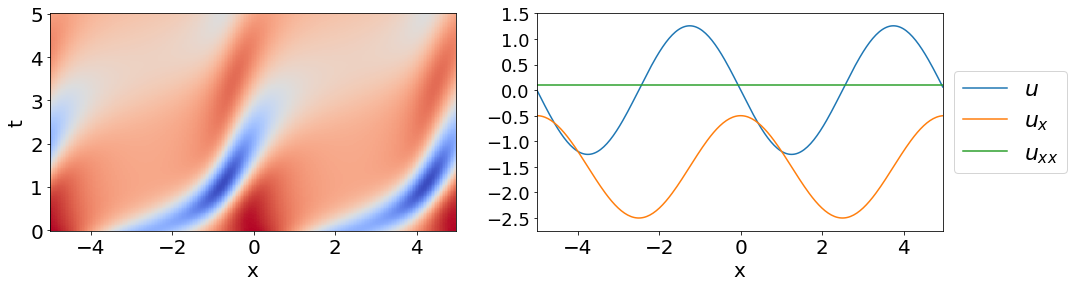

In [4]:
# Plot
u_x_true = -1.5 + 1.0*np.cos(2*x*np.pi/L) 
u_true = -2*np.pi/L*np.sin(2*x*np.pi/L)
u_xx_true = 0.1*np.ones(n)

fig = figure(figsize=(16,4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlim([x[0],x[-1]])

subplot(1,2,2)
plot(x,u_true, label='$u$')
plot(x,u_x_true, label='$u_{x}$')
plot(x,u_xx_true, label='$u_{xx}$')
xlim([x[0],x[-1]])
ylim([-2.75, 1.5])

xticks(fontsize = fontsize)
yticks(fontsize = fontsize-2)
xlabel('x', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# fig.tight_layout()

In [5]:
noise_lv = 1
noise_lv = abs(noise_lv)
u = u + 0.01*noise_lv*std(u)*np.random.randn(*u.shape)

In [6]:
Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, time_diff = 'FD', space_diff = 'Fourier')

In [7]:
Theta_grouped = [real(Theta[n*np.arange(m)+j,:]) for j in range(n)]
Ut_grouped = [real(Ut[n*np.arange(m)+j]) for j in range(n)]

In [8]:
xi_true = np.zeros((len(rhs_des),m))
i_u_x = [i for i in range(len(rhs_des)) if rhs_des[i] == 'u_{x}'][0]
xi_true[i_u_x,:] = u_x_true

1 u
2 u^2
3 u^3
4 u_{x}
5 uu_{x}
6 u^2u_{x}
7 u^3u_{x}
10 u^2u_{xx}
11 u^3u_{xx}
12 u_{xxx}
14 u^2u_{xxx}
15 u^3u_{xxx}
18 u^2u_{xxxx}
19 u^3u_{xxxx}
MSE:  5.289533850502663


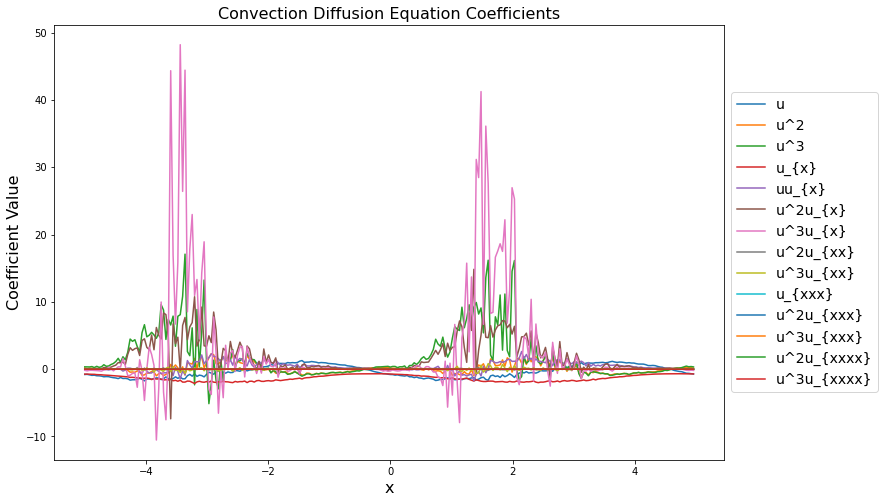

In [9]:
# Solve and plot
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        print(j, rhs_des[j])
        plot(x, xi[j,:], label = rhs_des[j])
                
title('Convection Diffusion Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_clean_sgtr = Norm(xi-xi_true)**2/(m*len(rhs_des))
print('MSE: ', mse_clean_sgtr)

In [10]:
def error(est, ground): return 100*np.linalg.norm(est-ground, 1)/np.linalg.norm(ground, 1)
u_pred, u_x_pred, u_xx_pred = xi[1,:], xi[4,:], xi[8,:]
errs = np.array([error(u_pred, u_true), error(u_x_pred, u_x_true), error(u_xx_pred, u_xx_true)])
errs.mean(), errs.std()

(55.19955886606351, 33.12608150774221)

In [11]:
Theta_grouped, Ut_grouped = [], []
Theta_val_grouped, Ut_val_grouped = [], []
n_domain = 4000
div = 32 # 16, 32: collect results from multiple div -> better!
candidates = set()

for xsub in np.arange(0, len(x), div):
    print(xsub, '-->', xsub+div)
    weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x], 
                                     function_names=[lambda x: x], 
                                     derivative_order=2, p=4, 
                                     spatiotemporal_grid=np.asarray(np.meshgrid(x[xsub:xsub+div], t)).T, 
                                     include_bias=False, is_uniform=True, K=n_domain
                                    )
    X_weak = weak_pde_lib.fit_transform(np.expand_dims(u[xsub:xsub+div, :], -1))
    y_weak = weak_pde_lib.convert_u_dot_integral(np.expand_dims(u[xsub:xsub+div, :], -1))
    
    Theta_grouped.append(X_weak[:n_domain//2, :])
    Ut_grouped.append(y_weak[:n_domain//2, :])
    
    Theta_val_grouped.append(X_weak[n_domain//2:, :])
    Ut_val_grouped.append(y_weak[n_domain//2:, :])
    
    candidates = candidates.union(set(solvel0(X_weak, y_weak, max_complexity=X_weak.shape[-1], 
                                              miosr=True, refine=False, verbose=False)))
    
max_complexity = len(weak_pde_lib.get_feature_names())
candidates

0 --> 32
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-04
32 --> 64
64 --> 96
96 --> 128
128 --> 160
160 --> 192
192 --> 224
224 --> 256


{(0, 1),
 (0, 1, 2),
 (0, 1, 2, 3),
 (0, 1, 2, 3, 4),
 (0, 1, 3),
 (0, 1, 3, 4),
 (0, 1, 4),
 (1,),
 (1, 2),
 (1, 2, 3),
 (1, 3)}

In [12]:
track = {}
lam = 1e-4 # 1 -> 1e-1 -> 1e-2 -> ... ผ่าน assert ได้เอาเลย
for indices in candidates:
    com = len(indices)
    rss = 0
    for j in range(len(Ut_grouped)):
        est_xi = Ridge(alpha=lam, fit_intercept=False).fit(Theta_grouped[j][:, indices], Ut_grouped[j]).coef_.reshape(-1, 1)
        difference = Ut_val_grouped[j] - Theta_val_grouped[j][:, indices].dot(est_xi)
        data_fit = np.linalg.norm(difference, 2)**2
        reg_loss = np.linalg.norm(est_xi, 2)**2
        assert data_fit/reg_loss > lam
        rss += data_fit + lam*reg_loss
    if com not in track or track[com][1] > rss:
        track[com] = indices, rss
candidates = set([e[0] for e in list(track.values())])
track

{2: ((0, 1), 0.03706621256512183),
 4: ((0, 1, 2, 3), 0.035470764081175714),
 3: ((0, 1, 2), 0.03610541816261835),
 1: ((1,), 0.06585148951385598),
 5: ((0, 1, 2, 3, 4), 0.03510114515646649)}

In [13]:
# n_domain = 5000
# weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x], 
#                                  function_names=[lambda x: x], 
#                                  derivative_order=2, p=4, 
#                                  spatiotemporal_grid=np.asarray(np.meshgrid(x, t)).T, 
#                                  include_bias=False, is_uniform=True, K=n_domain, 
#                                  include_interaction=True
#                                 )
# X_weak  = weak_pde_lib.fit_transform(np.expand_dims(u, -1))
# y_weak = weak_pde_lib.convert_u_dot_integral(np.expand_dims(u, -1))

In [14]:
## {(0, 1): -24870.435182938738, (1,): -22905.246319679856, (0, 1, 2, 3): -20228.688020764217, 
##  (0, 1, 2): -26770.420606213185, (0, 1, 2, 3, 4): -23082.227201239923}

# krr_bics = {}
# kf = KFold(n_splits=5)
# for i, (train_index, val_index) in enumerate(kf.split(X_weak)):
#     X_train, y_train = X_weak[train_index, :], y_weak[train_index, :]
#     X_val, y_val = X_weak[val_index, :], y_weak[val_index, :]
#     for indices in candidates:
#         krr = KernelRidge(kernel='rbf', alpha=0)
#         krr.fit(X_train[:, indices], y_train)
#         krr_bic = BIC_AIC(krr.predict(X_val[:, indices]), y_val, nparams=len(indices))[0]
#         if tuple(indices) not in krr_bics:
#             krr_bics[tuple(indices)] = krr_bic
#         else:
#             krr_bics[tuple(indices)] += krr_bic
# print(krr_bics)

5


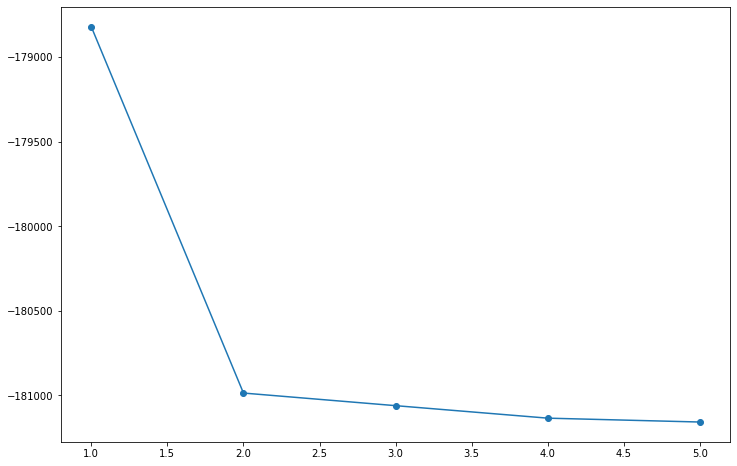

In [15]:
ic_scores = {}
for indices in candidates:
    est_xi = np.zeros((Theta_grouped[0].shape[-1], len(Ut_grouped)))
    for j in range(len(Theta_grouped)):
        est_xi[indices, j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, indices], Ut_grouped[j], rcond=None)[0]
    aic = PDE_FIND_Loss(Theta_grouped, Ut_grouped, est_xi)
    bic = BIC_Loss(Theta_grouped, Ut_grouped, est_xi)
    if len(indices) not in ic_scores: ic_scores[len(indices)] = (aic, bic, indices)
    elif aic < ic_scores[len(indices)][0]: ic_scores[len(indices)] = (aic, bic, indices)

com_ics = sorted([(len(e[2]), e[0], e[1]) for e in list(ic_scores.values())])
complexities = [e[0] for e in com_ics]
aics = [e[1] for e in com_ics]
bics = [e[2] for e in com_ics]
print(complexities[np.argmin(aics)])
plt.plot(complexities, aics, '-o'); plt.show()

5


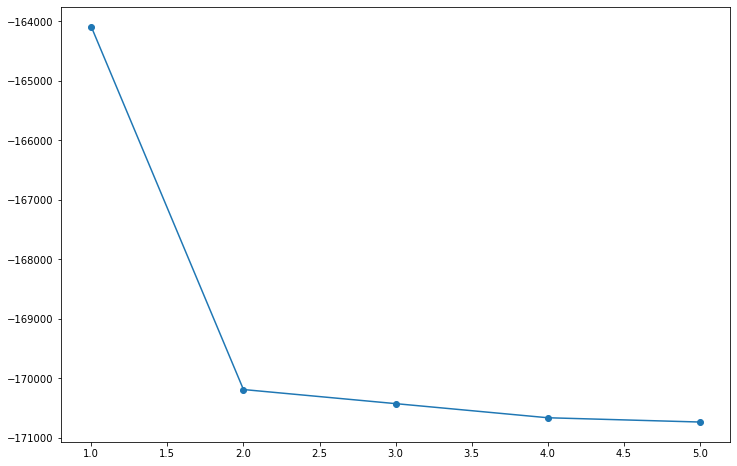

In [16]:
print(complexities[np.argmin(bics)])
plt.plot(complexities, bics, '-o'); plt.show()

epsilon 2.4001223439646603e-05
3
(0, 1, 2)


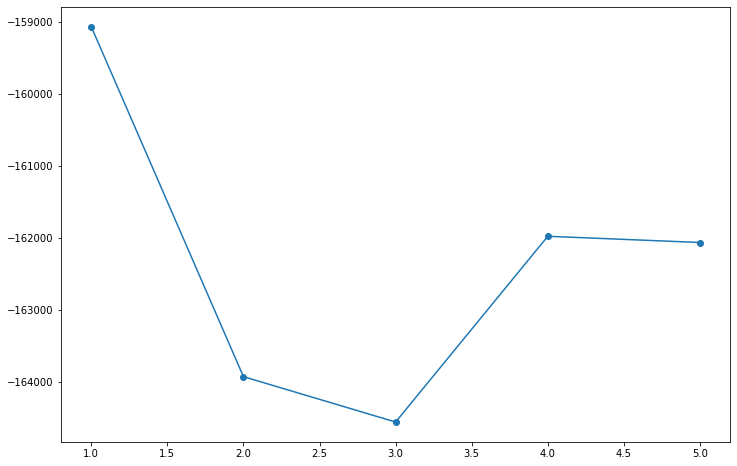

In [17]:
best_subsets = {}
for indices in candidates:
    est_xi = []
    uncert = 0.0
    rss = 0.0
    for j in range(len(Theta_grouped)):
        # fit_brr
        # brr = BayesianRidge(fit_intercept=False)
        # brr.fit(Theta_grouped[j][:, indices], Ut_grouped[j].ravel())
        # post_mean, post_cov = brr.coef_.reshape(-1, 1), brr.sigma_
        
        # post_mean, post_cov = fit_blr(Theta_grouped[j][:, indices], Ut_grouped[j])
        # uncert = uncert + np.sqrt(np.diag(post_cov)).sum()/abs(post_mean).sum() # OPTION_1
        # uncert = uncert + np.mean(np.sqrt(np.diag(post_cov))/abs(post_mean)) # OPTION_2
        # post_prediction = Theta_val_grouped[j][:, indices].dot(post_mean)
        
        krr = KernelRidge(kernel='rbf', alpha=0)
        krr.fit(Theta_grouped[j][:, indices], Ut_grouped[j])
        post_prediction = krr.predict(Theta_val_grouped[j][:, indices])
        est_xi.append(krr.dual_coef_.reshape(-1, 1))
        
        rss = rss + np.linalg.norm(Ut_val_grouped[j] - post_prediction)**2
        
    uncert = np.hstack(est_xi)
    # uncert = uncert.std(axis=1).sum()/np.abs(uncert.mean(axis=1)).sum()
    uncert = np.mean(uncert.std(axis=1)/np.abs(uncert.mean(axis=1)))
        
    if len(indices) not in best_subsets: best_subsets[len(indices)] = (rss, uncert, indices)
    elif rss < best_subsets[len(indices)][0]: best_subsets[len(indices)] = (rss, uncert, indices)
        
nobs = Theta_grouped[0].shape[0]*len(Ut_grouped)
min_uncert = np.min([best_subsets[com][1] for com in best_subsets])
epsilon = max(1e-5, 
              np.max([2*np.pi*best_subsets[com][0]/nobs for com in best_subsets]))
print("epsilon", epsilon)
complexities = sorted(best_subsets.keys())
bics = []
uncertainties = []
for com in complexities:
    rss, uncert, indices = best_subsets[com]
    uncert = uncert/min_uncert
    uncertainties.append(uncert)
    bics.append(rss2bic(rss, com+uncert, nobs, epsilon))
uncertainties = np.array(uncertainties)
best_indices = best_subsets[complexities[np.argmin(bics)]][-1]
print(complexities[np.argmin(bics)])
print(best_indices)
plt.plot(complexities, bics, '-o'); plt.show()

In [18]:
verbose = True
tau = 3
b_bics = []
lower_bounds = []
for com in complexities:
    rss, _, indices = best_subsets[com]
    assert com == len(indices)
    lower_bound = 2*ssr2llf(rss, nobs)/np.log(nobs)-com
    lower_bounds.append(lower_bound)
    b_bics.append(rss2bic(rss, com, nobs, epsilon))
    
last_lam = np.log10(max(max(lower_bounds/uncertainties), 0))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, uncertainties, nobs, hyp=10**last_lam)
last_bc = np.argmin(last_ubic)

thres = 1e-4
percent = 75
b_bics = np.array(b_bics)
complexities = np.array(complexities)
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = max(thres, np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), percent))

while now_lam >= 0:
    now_ubic = UBIC(b_bics, uncertainties, nobs, hyp=10**now_lam)
    now_bc = np.argmin(now_ubic)

    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]

    imp = np.nan
    if diff_com > 0:
        imp = abs(diff_bic/(b_bics[last_bc]*diff_com))

    if verbose:
        print(last_bc, '--->', now_bc, np.nan_to_num(imp, nan=np.inf))

    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break

    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc
    now_lam = round(now_lam, 8)
    
last_lam = abs(round(last_lam, 8))
best_indices = best_subsets[complexities[last_bc]][-1]; print(best_indices, "selected")
last_lam, last_ubic, last_bc

2 ---> 2 inf
2 ---> 2 inf
2 ---> 2 inf
(0, 1, 2) selected


(0.0,
 array([-159064.66770975, -163928.28792434, -164558.95043653,
        -161977.22301485, -162063.94713208]),
 2)

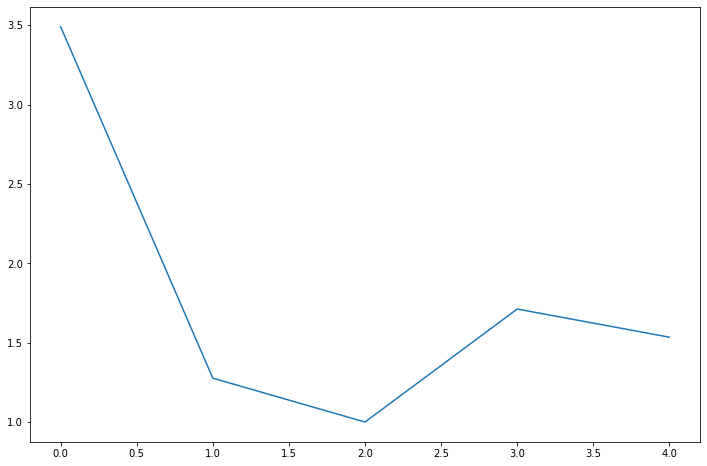

In [19]:
plt.plot(uncertainties); plt.show()

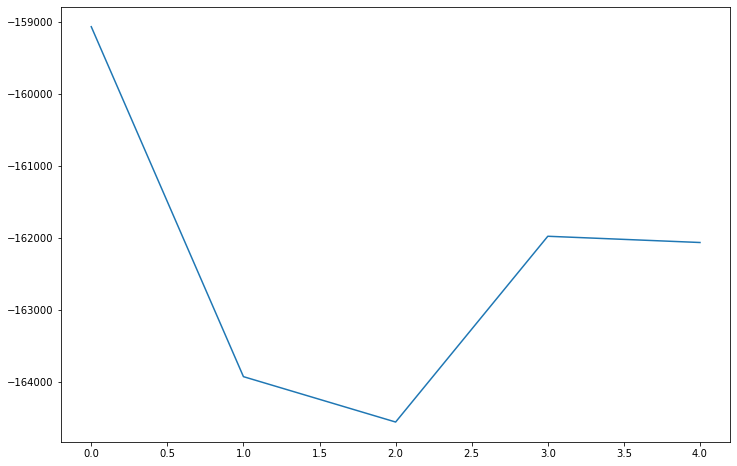

In [20]:
plt.plot(last_ubic); plt.show()